# Libraries

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import xticks


import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore  warning (from sklearn)

#print(os.listdir("../input"))

# Let's Load the Data

In [2]:
house_data = pd.read_csv('C:/Users/Sabby/Downloads/house-prices-advanced-regression-techniques/train.csv')
house_data_test = pd.read_csv('C:/Users/Sabby/Downloads/house-prices-advanced-regression-techniques/test.csv')
submission = pd.DataFrame(pd.read_csv('C:/Users/Sabby/Downloads/house-prices-advanced-regression-techniques/sample_submission.csv'))

In [3]:
print(house_data.shape)

(1460, 81)


In [4]:
print(house_data_test.shape)

(1459, 80)


In [5]:
print(house_data_test.head())

     Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461          20       RH         80.0    11622   Pave   NaN      Reg   
1  1462          20       RL         81.0    14267   Pave   NaN      IR1   
2  1463          60       RL         74.0    13830   Pave   NaN      IR1   
3  1464          60       RL         78.0     9978   Pave   NaN      IR1   
4  1465         120       RL         43.0     5005   Pave   NaN      IR1   

  LandContour Utilities  ... ScreenPorch PoolArea PoolQC  Fence MiscFeature  \
0         Lvl    AllPub  ...         120        0    NaN  MnPrv         NaN   
1         Lvl    AllPub  ...           0        0    NaN    NaN        Gar2   
2         Lvl    AllPub  ...           0        0    NaN  MnPrv         NaN   
3         Lvl    AllPub  ...           0        0    NaN    NaN         NaN   
4         HLS    AllPub  ...         144        0    NaN    NaN         NaN   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  
0       0      6

# EDA

AxesSubplot(0.125,0.125;0.775x0.755)


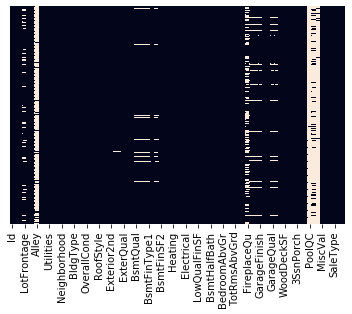

In [6]:
#81 features - need a lot. analyzing.
#heatmap to visualize the null values
print(sns.heatmap(house_data.isnull(),yticklabels=False,cbar=False))

plt.savefig('C:/Users/Sabby/Downloads/house-prices-advanced-regression-techniques/heatmapNull.png', dpi=300, bbox_inches='tight')


In [7]:
# Let's display the variables with more than 0 null values
null_cols = []
for col in house_data.columns:
    if house_data[col].isnull().sum() > 0 :
        house_data[col].isnull().sum()    
        null_cols.append(col)

In [8]:
NAN = [(c, house_data[c].isna().mean()*100) for c in house_data]
NAN = pd.DataFrame(NAN, columns=["column_name", "percentage"])
NAN = NAN[NAN.percentage > 30]
print(NAN.sort_values("percentage", ascending=False))

    column_name  percentage
72       PoolQC   99.520548
74  MiscFeature   96.301370
6         Alley   93.767123
73        Fence   80.753425
57  FireplaceQu   47.260274


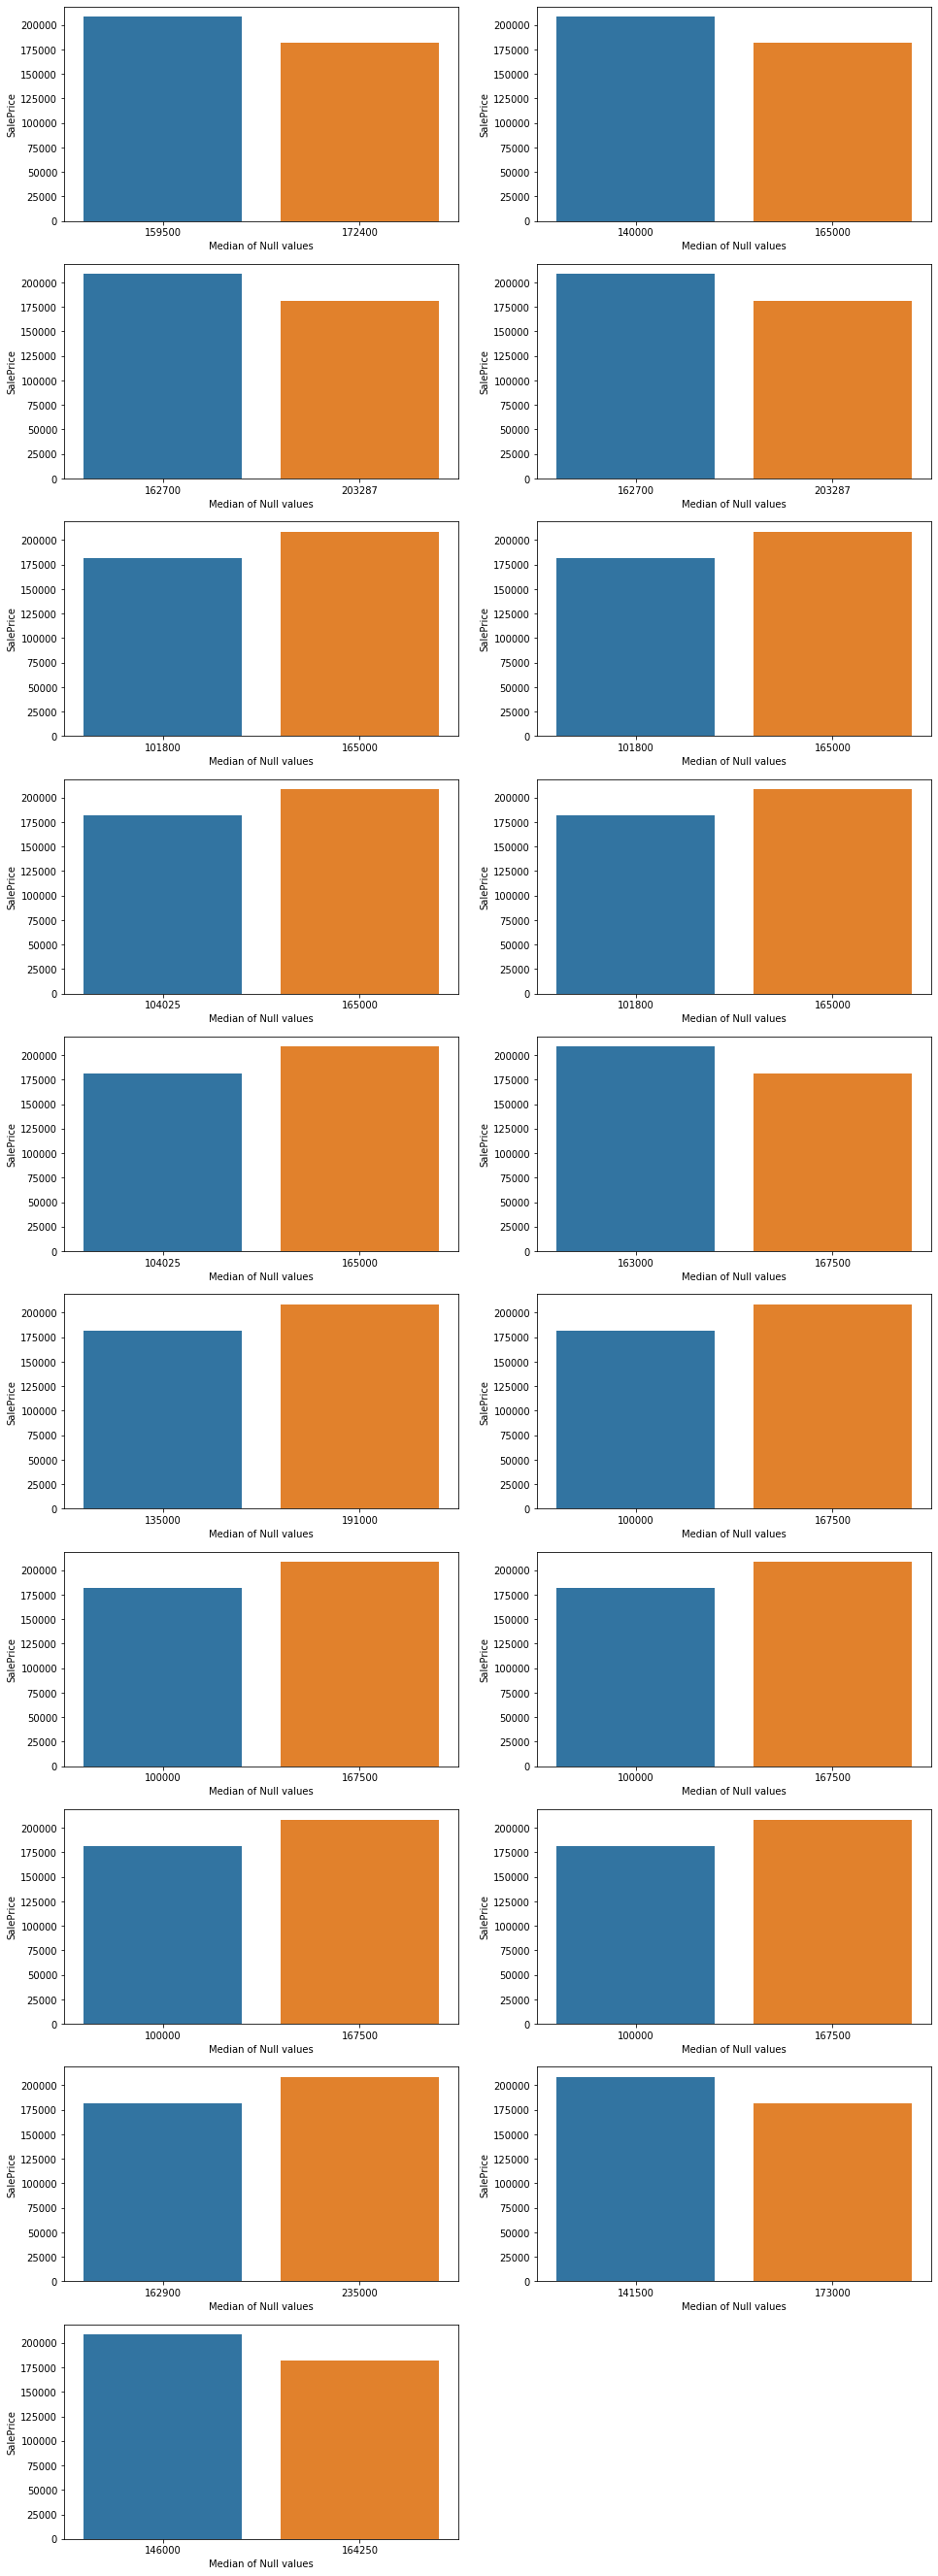

<Figure size 432x288 with 0 Axes>

In [9]:
# lets check if these null values actually have any relation with the target variable

house_data_eda = house_data.copy()

for col in null_cols:
    house_data_eda[col] = np.where(house_data_eda[col].isnull(), 1, 0)  

# lets see if these null values have to do anything with the sales price
plt.figure(figsize = (16,48))
for idx,col in enumerate(null_cols):
    plt.subplot(10,2,idx+1)
    sns.barplot(x = house_data_eda.groupby(col)["SalePrice"].median(),y =house_data_eda["SalePrice"])
    plt.xlabel("Median of Null values")
plt.show()

plt.savefig('C:/Users/Sabby/Downloads/house-prices-advanced-regression-techniques/nullvsSalePrice.png', dpi=300, bbox_inches='tight')



<font color='blue'>Categorizing & Numerical Data </font>

In [10]:
#Selecting numerical and categorical types
object_columns_df = house_data.select_dtypes(include=['object'])
numerical_columns_df =house_data.select_dtypes(exclude=['object'])
#Found the number of null values for object and numerical

<font>Plotting to check for Variance</font>

In [11]:
# lets firs create seperate lists of categorical and numeric columns
cat_vars = []
num_vars = []
for col in house_data.columns:
    if house_data[col].dtypes == 'O':
        cat_vars.append(col)
    else:
        num_vars.append(col)


In [12]:
# Let's further seperate the numeric features into continous and discrete numeric features
num_cont = []
num_disc = []
for col in num_vars:
    if house_data[col].nunique() > 25: # if variable has more than 25 different values, we consider it as continous variable
        num_cont.append(col)
    else:
        num_disc.append(col)

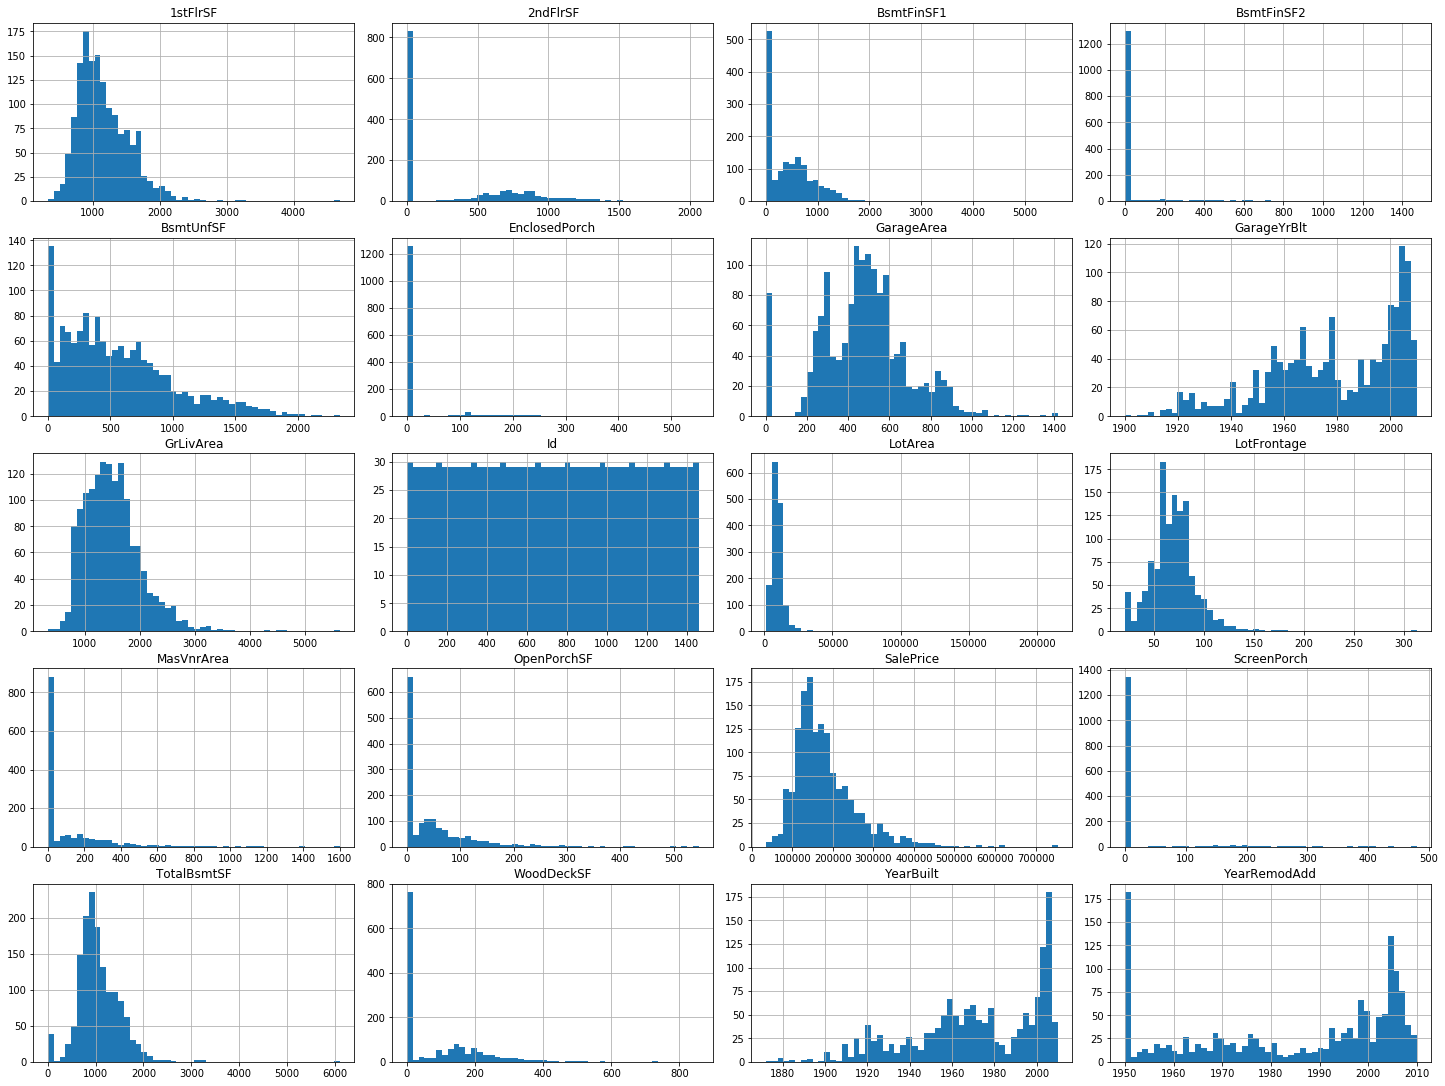

<Figure size 432x288 with 0 Axes>

In [13]:
# lets check for the variance in the different continous numeric columns present in the dataset
house_data.hist(num_cont,bins=50, figsize=(20,15))
plt.tight_layout(pad=0.4)
plt.show()

plt.savefig('C:/Users/Sabby/Downloads/house-prices-advanced-regression-techniques/NumContin.png', dpi=300, bbox_inches='tight')


**Following variables seems to have low variance:**
* MasVnArea
* BsmtFinSF2
* 2ndFlrSF
* EnclosedPorch
* ScreenPorch

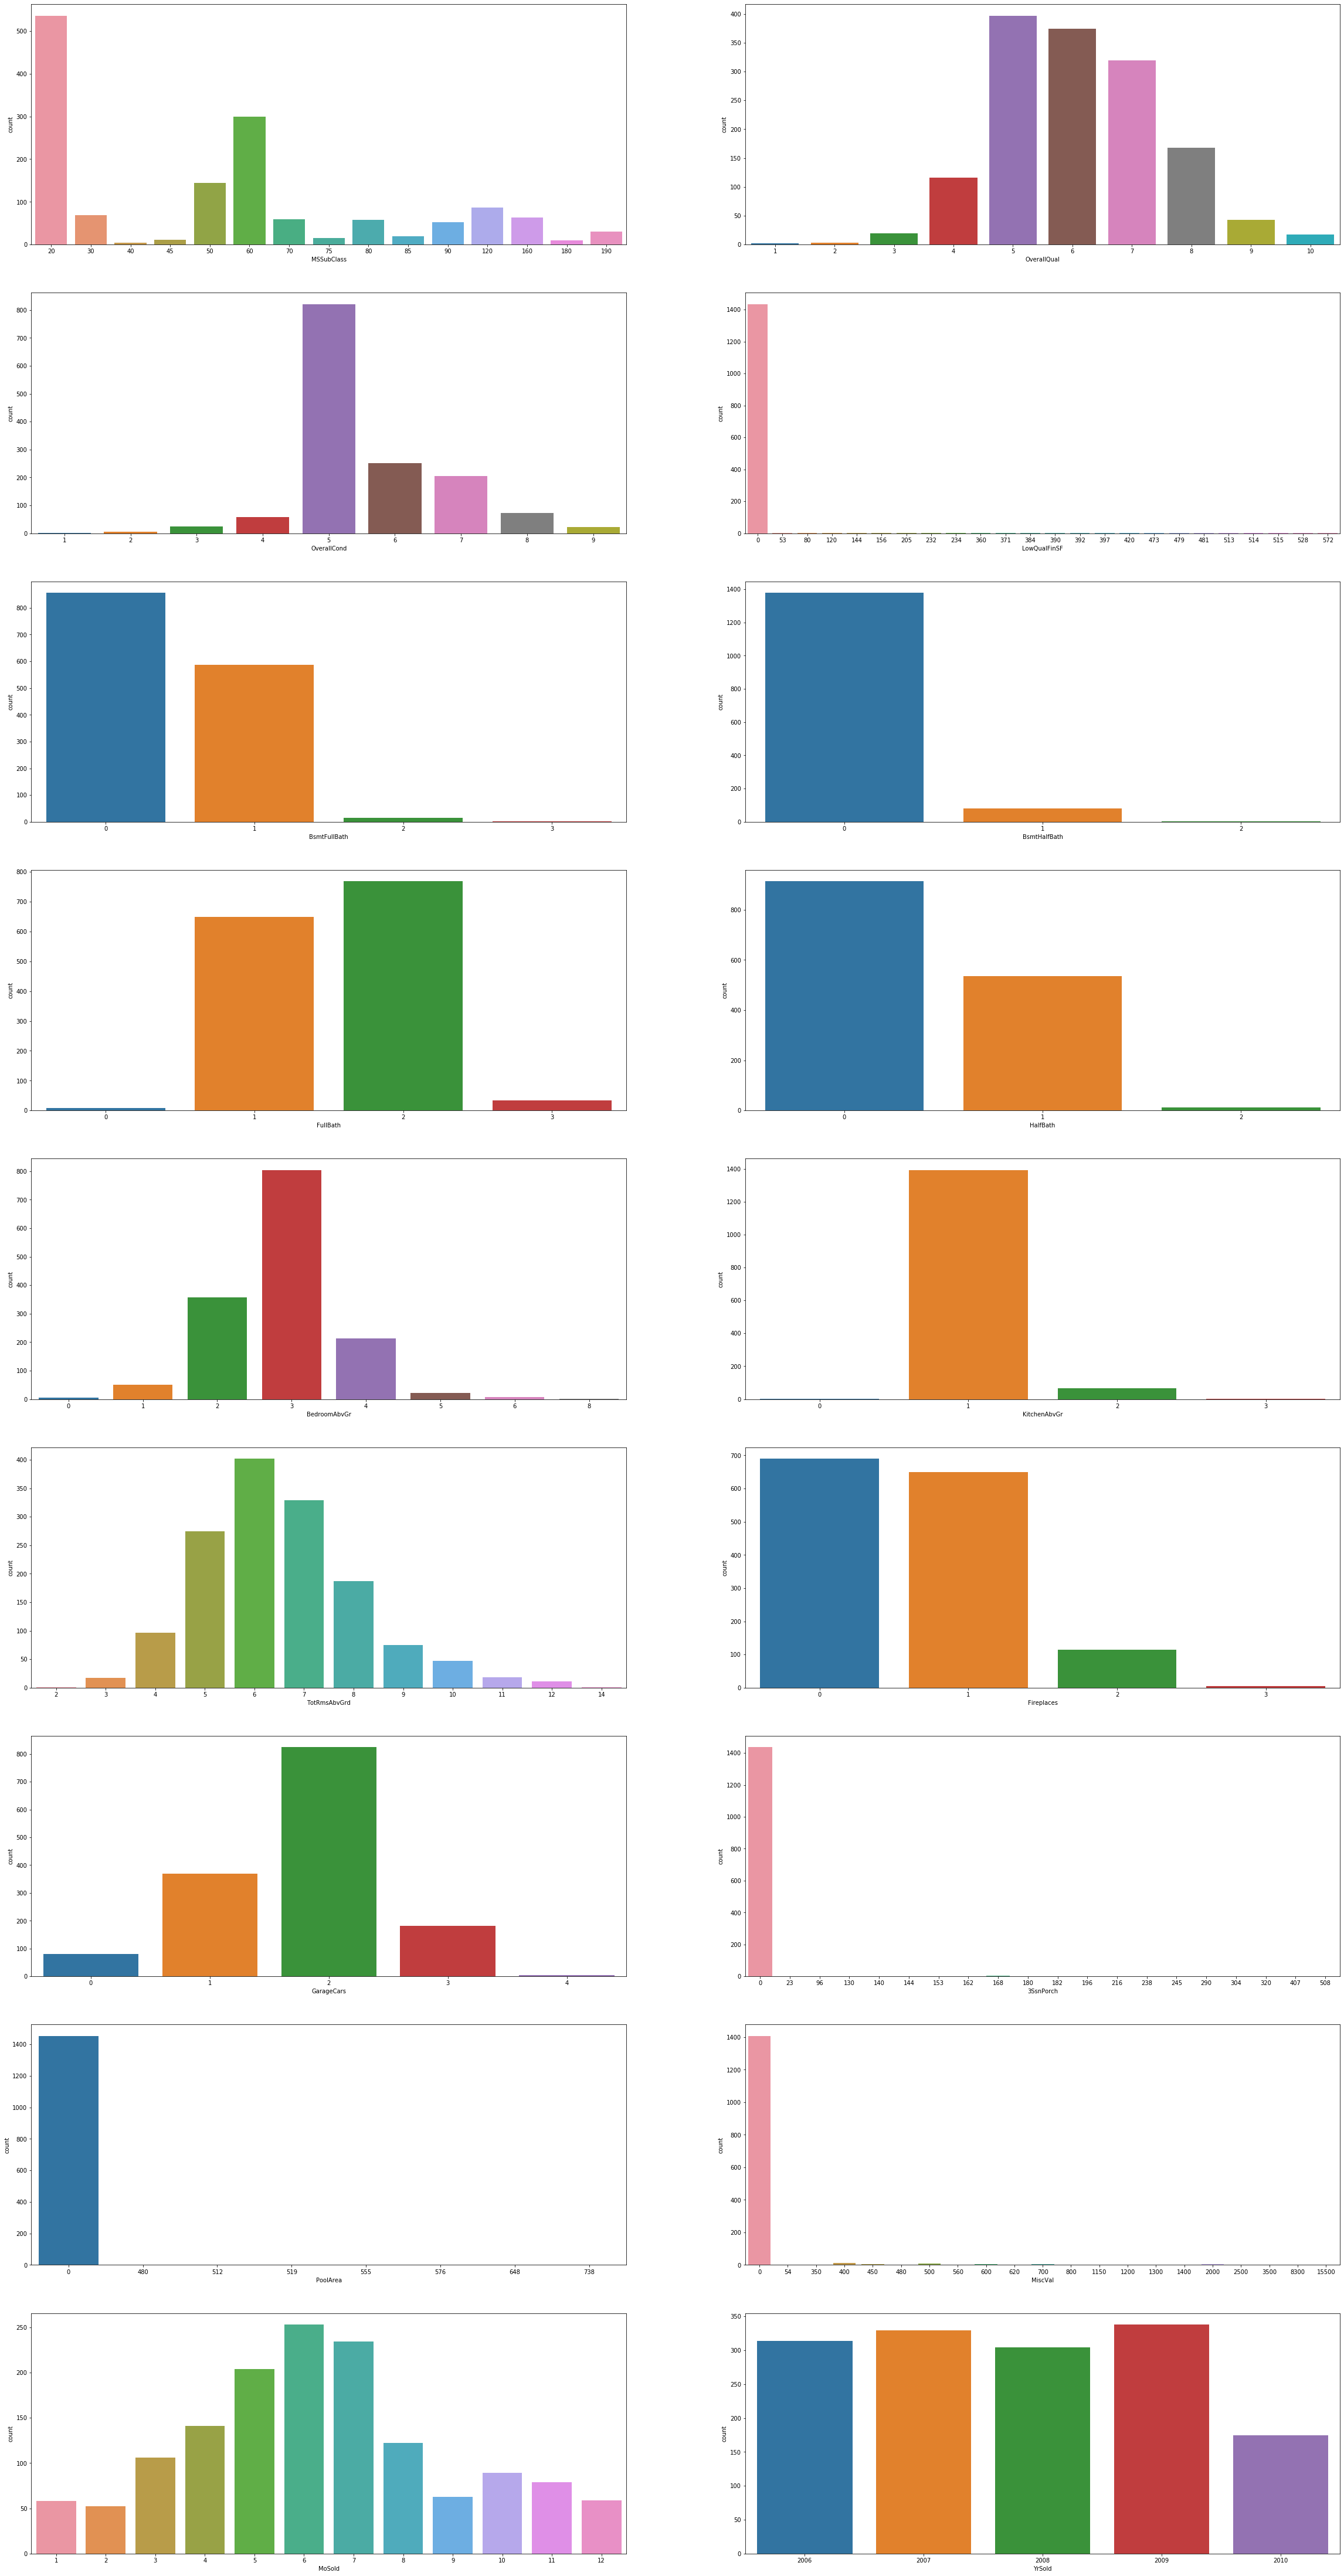

In [14]:
# lets check for the variance in the different discrete numeric columns present in the dataset
plt.figure(figsize = (40,80))
for idx,col in enumerate(num_disc):
    plt.subplot(9,2,idx+1)
    ax=sns.countplot(house_data[col])
    
plt.savefig('C:/Users/Sabby/Downloads/house-prices-advanced-regression-techniques/NumDiscrete.png', dpi=300, bbox_inches='tight')


**following variables seems to have low variance:**
* **LowQualFinSF**
* **BsmtHalfBath**
* **KitchenAbvGr**
* **3SsnPorch**
* **PoolArea**
* **MiscVal**

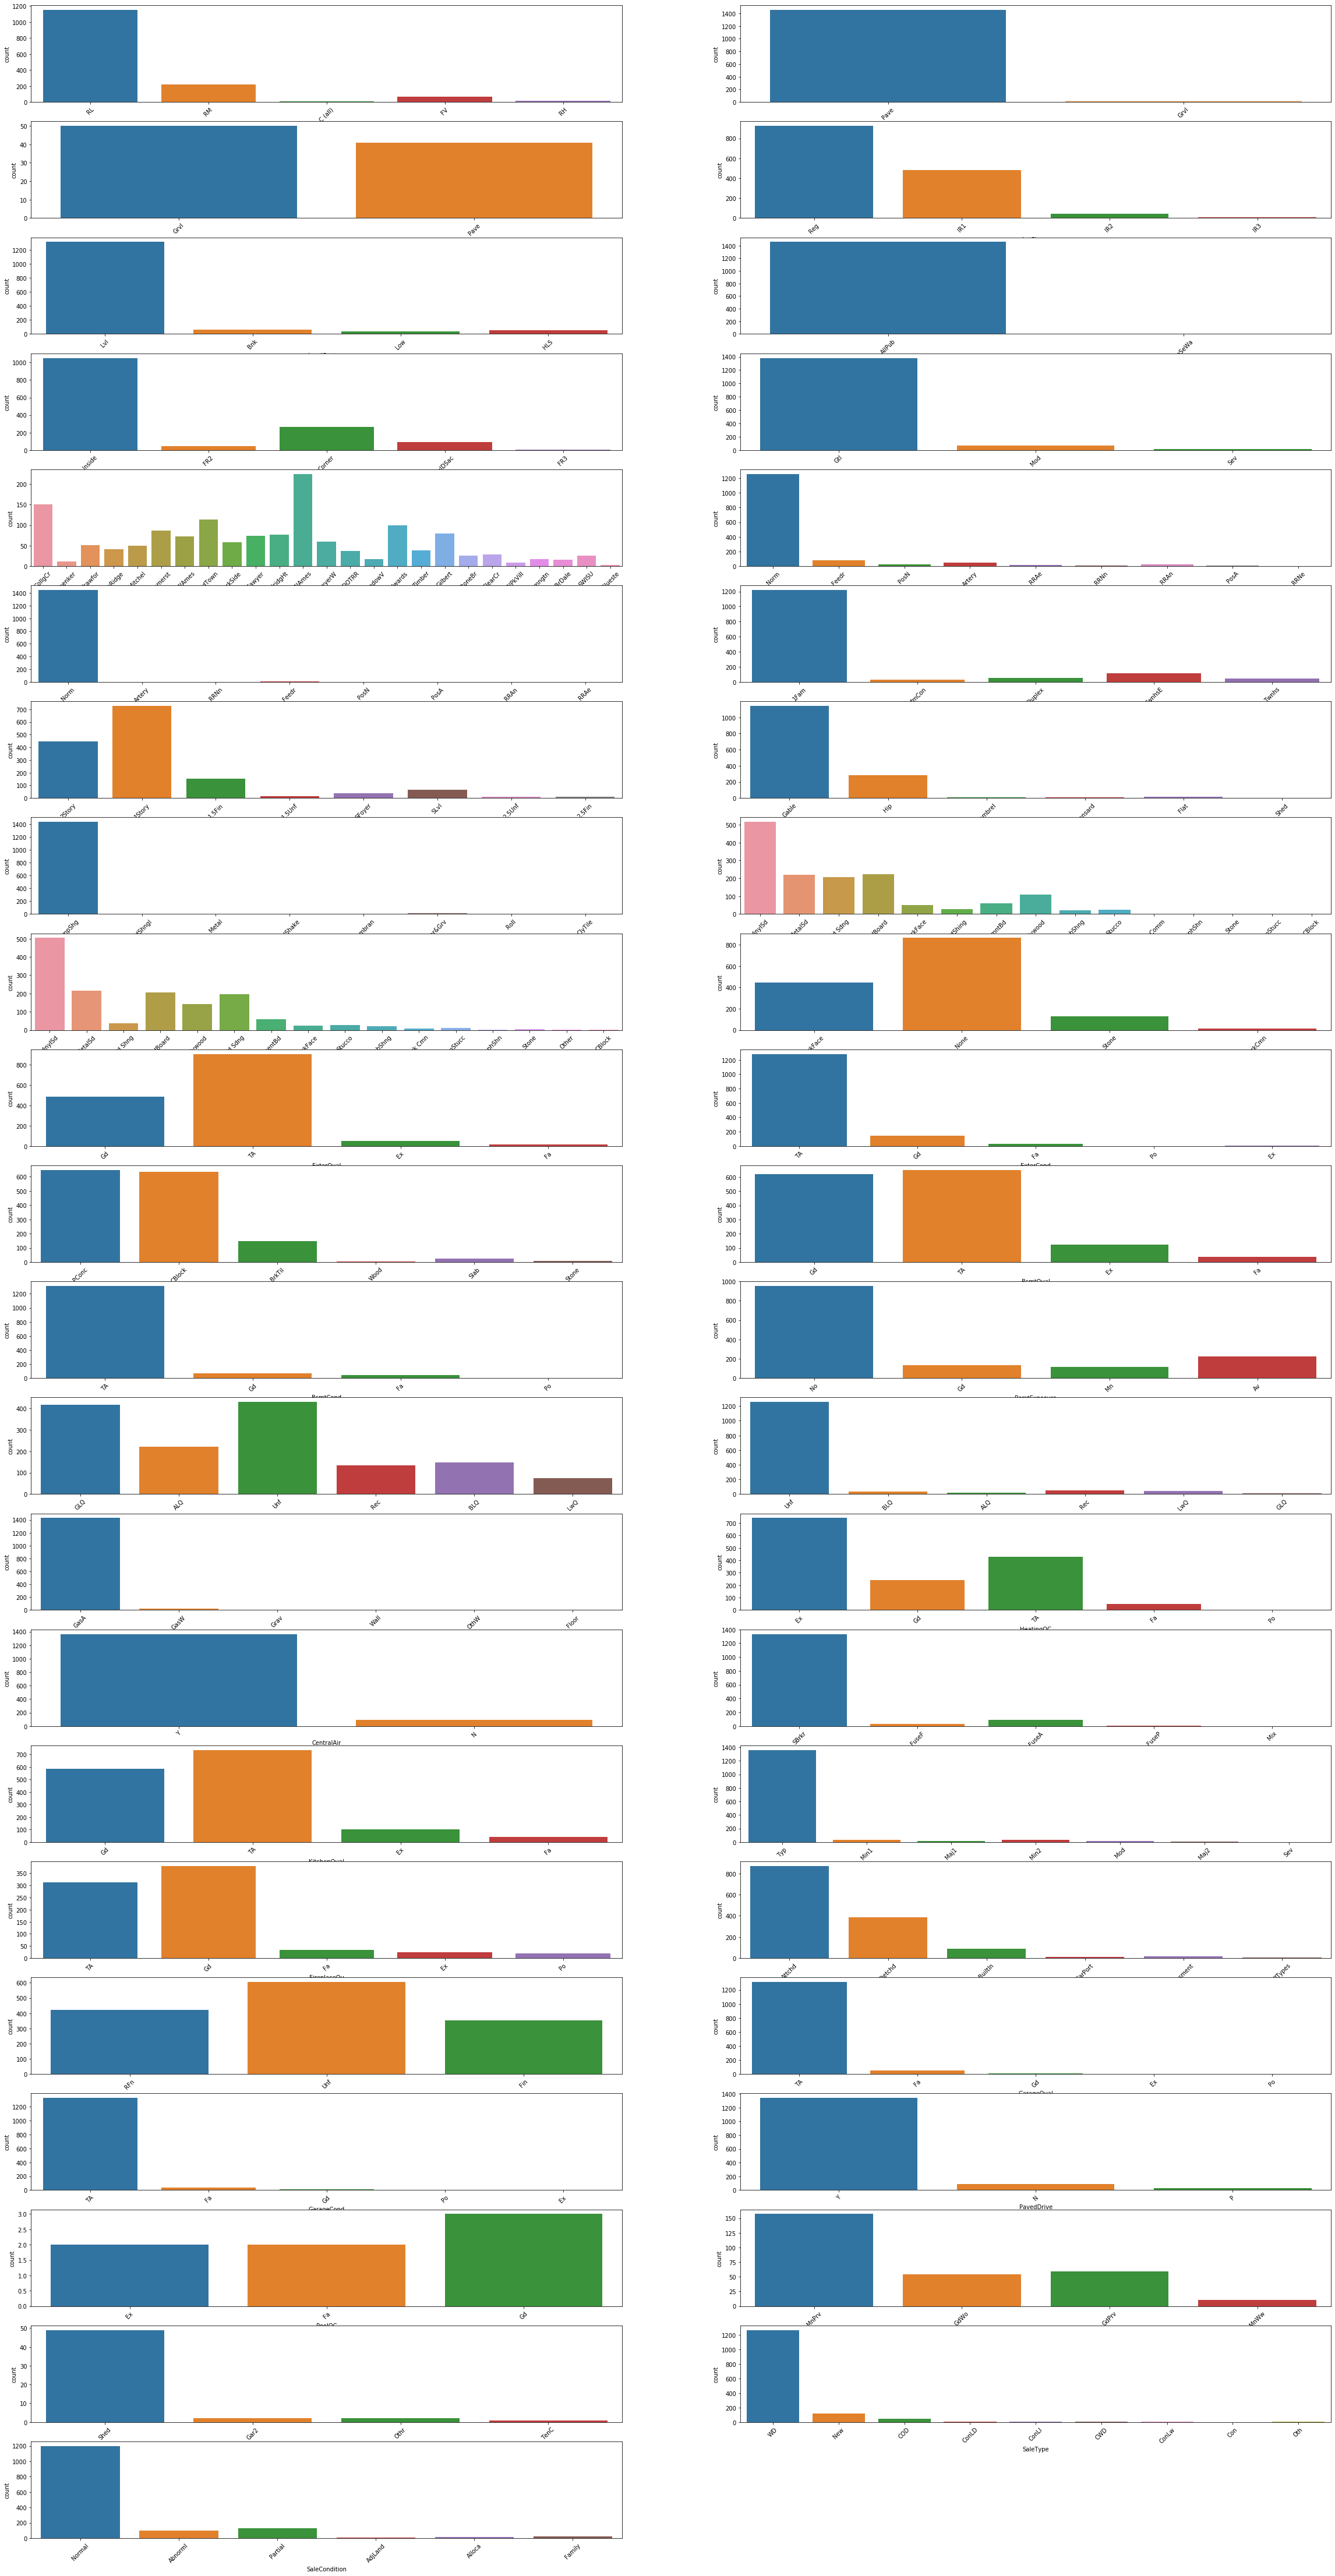

In [15]:
# lets check for the variance in the categorical columns present in the dataset
plt.figure(figsize = (40,80))
for idx,col in enumerate(cat_vars):
    plt.subplot(22,2,idx+1)
    ax=sns.countplot(house_data[col])
    xticks(rotation=45)
    #for p in ax.patches:
    #    ax.annotate(p.get_height(), (p.get_x()+0.25, p.get_height()+5))
    
plt.savefig('C:/Users/Sabby/Downloads/house-prices-advanced-regression-techniques/Categorical.png', dpi=300, bbox_inches='tight')



# Data Cleaning

Will store the Id column(information) from test dataframe ,in test_parent dataframe.

Then let's drop the Id column from both test and train data. 

In [16]:
train_parent=house_data
test_parent=house_data_test 
house_data = house_data.drop('Id', axis=1)
house_data_test = house_data_test.drop('Id', axis=1)

Now we will analyze the NaN values present in the dataset and deal with them .

In [17]:
#We will find all the columns which have more than 40 % NaN data and drop then
threshold=0.4 * len(house_data)
df=pd.DataFrame(len(house_data) - house_data.count(),columns=['count'])
df.index[df['count'] > threshold]

Index(['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], dtype='object')

In [18]:
house_data = house_data.drop(['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], axis=1)
house_data_test = house_data_test.drop(['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], axis=1)

Will verify that the Label is a numeric data

In [19]:
house_data['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Find all the numeric columns and replace the NaN values with 0 ,
and for categorical columns ,replace NaN values with 'None'.

In [20]:
house_data.select_dtypes(include=np.number).columns #will give all numeric columns ,we will remove the SalePrice column 
for col in ('MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'):
    
    house_data[col] = house_data[col].fillna(0)
    house_data_test[col] = house_data_test[col].fillna('0')

In [21]:
house_data.select_dtypes(exclude=np.number).columns
for col in ('MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition'):
    
    house_data[col] = house_data[col].fillna('None')
    house_data_test[col] = house_data_test[col].fillna('None')

**Removing the outliers**

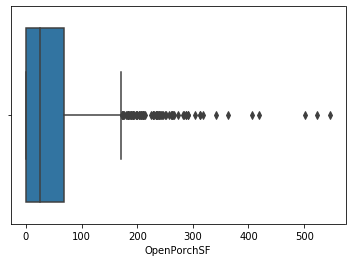

In [22]:
sns.boxplot(house_data.OpenPorchSF)

In [23]:
### Outliars Detection
outliers_list = ['']
house_data['OpenPorchSF']= house_data['OpenPorchSF'].clip_upper(house_data['OpenPorchSF'].quantile(0.99))

house_data['GarageArea']= house_data['GarageArea'].clip_upper(house_data['GarageArea'].quantile(0.99))
house_data['TotalBsmtSF']= house_data['TotalBsmtSF'].clip_upper(house_data['TotalBsmtSF'].quantile(0.99)) 
house_data['BsmtUnfSF']= house_data['BsmtUnfSF'].clip_upper(house_data['BsmtUnfSF'].quantile(0.99))
house_data['WoodDeckSF']= house_data['WoodDeckSF'].clip_upper(house_data['WoodDeckSF'].quantile(0.99))
house_data['BsmtFinSF1']= house_data['BsmtFinSF1'].clip_upper(house_data['BsmtFinSF1'].quantile(0.99))

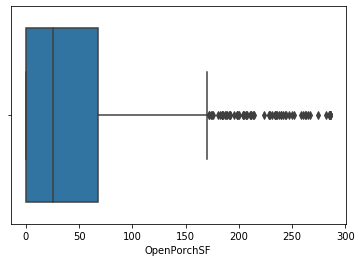

In [24]:
sns.boxplot(house_data.OpenPorchSF)

Verify that there are no null values in the data set

In [25]:
house_data[house_data.isnull().any(axis=1)]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


In [26]:
house_data_test[house_data_test.isnull().any(axis=1)]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition


# Label Encoding 

 **Combining the two datasets and then doing One Hot Encoding on the combined dataset.**

In [27]:
train=house_data
test=house_data_test

#Assigning a flag to training and testing dataset for segregation after OHE .
train['train']=1 
test['train']=0

#Combining training and testing dataset

combined=pd.concat([train,test])

In [28]:
#Applying One Hot Encoding to categorical data
ohe_data_frame=pd.get_dummies(combined, 
                           columns=['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition'],
      )

# Feature Selection

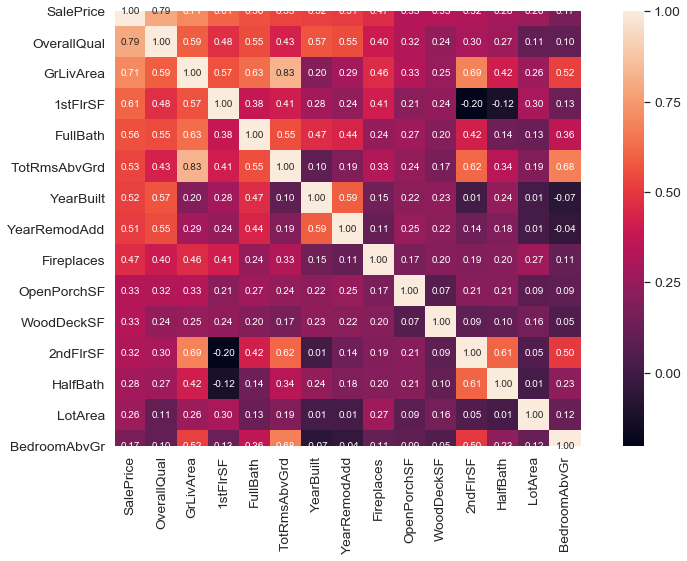

<Figure size 432x288 with 0 Axes>

In [29]:
#saleprice correlation matrix
k = 15 #number of variables for heatmap
plt.figure(figsize=(15,8))
corrmat = combined.corr()
# picking the top 15 correlated features
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

plt.savefig('C:/Users/Sabby/Downloads/house-prices-advanced-regression-techniques/correaltion.png', dpi=300, bbox_inches='tight')


In [30]:
cols

Index(['SalePrice', 'OverallQual', 'GrLivArea', '1stFlrSF', 'FullBath',
       'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd', 'Fireplaces',
       'OpenPorchSF', 'WoodDeckSF', '2ndFlrSF', 'HalfBath', 'LotArea',
       'BedroomAbvGr'],
      dtype='object')

# Splitting 

In [31]:
#Splitting the combined dataset after doing OHE .
train_df=ohe_data_frame[ohe_data_frame['train']==1]
test_df=ohe_data_frame[ohe_data_frame['train']==0]


In [32]:
target=train_df['SalePrice']

In [33]:
#train_df.drop(['train'],axis=1,inplace=True)  #Drop the Flag(train) coloumn from training dataset
train_df.drop(['SalePrice'],axis=1,inplace=True)


In [34]:
#test_df=test_df.drop(['train'],axis=1)
test_df.drop(['SalePrice'],axis=1,inplace=True)     #Drop the Flag(train),Label(SalePrice) coloumn from test dataset

In [35]:
house_data=train_df
house_data_test=test_df

In [36]:
house_data_test.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,...,SaleType_New,SaleType_None,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,896,0,0,2,468,144,0,0,270,0,...,0,0,0,1,0,0,0,0,1,0
1,1329,0,0,3,923,0,0,0,406,0,...,0,0,0,1,0,0,0,0,1,0
2,928,701,0,3,791,0,0,0,137,0,...,0,0,0,1,0,0,0,0,1,0
3,926,678,0,3,602,0,0,0,324,0,...,0,0,0,1,0,0,0,0,1,0
4,1280,0,0,2,263,0,0,0,1017,0,...,0,0,0,1,0,0,0,0,1,0


**Data Cleaning is now complete We can now use our data to build our models**

In [37]:
#splitting training data into training and validation
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(house_data,target,test_size=0.3,random_state=0)

# Scaling

In [38]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

In [39]:
#Using incremental PCA for efficiency - saves a lot of time on larger datasets
from sklearn.decomposition import IncrementalPCA
pca_final = IncrementalPCA(n_components=60)

In [40]:
pca_final.fit_transform(X_train)

array([[ 1.80036665, -0.18096509, -0.81491403, ...,  0.17933436,
         0.45340837, -0.07385172],
       [ 0.4667944 ,  0.03389221,  0.45143741, ..., -0.19353991,
         0.20797452, -0.18697104],
       [-1.56932936,  0.41727106,  0.81916937, ..., -0.08653967,
         0.01027607, -0.24493319],
       ...,
       [-0.91915849, -0.54045938,  0.00523257, ...,  0.31534374,
         0.02221338, -0.28782066],
       [ 2.05200315, -0.29693049,  0.4798341 , ..., -0.01609   ,
         0.00956473, -0.05709743],
       [ 1.45560872, -0.37781608, -1.09627614, ...,  0.20649899,
        -0.08219961, -0.17296203]])

In [41]:
pca_final.explained_variance_ratio_ 

array([0.15254867, 0.06251232, 0.03682977, 0.03391314, 0.03115275,
       0.0299266 , 0.02704934, 0.02364764, 0.02233477, 0.02081852,
       0.01997738, 0.01908503, 0.01797371, 0.01694493, 0.01623348,
       0.01585972, 0.0151232 , 0.01452812, 0.01378104, 0.01346015,
       0.01282588, 0.01257189, 0.01142739, 0.01082295, 0.01017262,
       0.00970112, 0.00958747, 0.0093267 , 0.00876711, 0.0086608 ,
       0.00821166, 0.00806009, 0.00777015, 0.00771279, 0.00740015,
       0.00705863, 0.00699329, 0.00666673, 0.00646554, 0.00615992,
       0.00596884, 0.00586125, 0.00564972, 0.00558801, 0.00551995,
       0.0053137 , 0.00519576, 0.00488589, 0.00466579, 0.0044895 ,
       0.00436507, 0.00425545, 0.00411363, 0.00400194, 0.00391235,
       0.00384242, 0.00365655, 0.00357295, 0.00332061, 0.00326814])

# Regression

from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.metrics import make_scorer
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.metrics import r2_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

# R2 Score

def lets_try(train,labels):
    results={}
    def test_model(clf):
        
        cv = KFold(n_splits=5,shuffle=True,random_state=45)
        r2 = make_scorer(r2_score)
        r2_val_score = cross_val_score(clf, train, labels, cv=cv,scoring=r2)
        scores=[r2_val_score.mean()]
        return scores

    clf = linear_model.LinearRegression()
    results["Linear"]=test_model(clf)
    
    clf = linear_model.Ridge()
    results["Ridge"]=test_model(clf)
    
    clf = linear_model.BayesianRidge()
    results["Bayesian Ridge"]=test_model(clf)
    
    clf = linear_model.HuberRegressor()
    results["Hubber"]=test_model(clf)
    
    clf = linear_model.Lasso(alpha=1e-4)
    results["Lasso"]=test_model(clf)
    
    clf = BaggingRegressor()
    results["Bagging"]=test_model(clf)
    
    clf = RandomForestRegressor()
    results["RandomForest"]=test_model(clf)
    
    clf = AdaBoostRegressor()
    results["AdaBoost"]=test_model(clf)
    
    clf = svm.SVR()
    results["SVM RBF"]=test_model(clf)
    
    clf = svm.SVR(kernel="linear")
    results["SVM Linear"]=test_model(clf)
    
    results = pd.DataFrame.from_dict(results,orient='index')
    results.columns=["R Square Score"] 
    results.plot(kind="bar",title="Model Scores")
    axes = plt.gca()
    axes.set_ylim([0.5,1])
    return results



#With PCA 
lets_try(X_train,Y_train)

# Gradient Boosting for regression

**find the best parameter for GBR using GridSearchCV    **

In [42]:
"""
from sklearn.model_selection import GridSearchCV

num_estimators = [500,1000,3000]
learn_rates = [0.01, 0.02, 0.05, 0.1]
max_depths = [1, 2, 3, 4]
min_samples_leaf = [5,10,15]
min_samples_split = [2,5,10]

param_grid = {'n_estimators': num_estimators,
              'learning_rate': learn_rates,
              'max_depth': max_depths,
              'min_samples_leaf': min_samples_leaf,
              'min_samples_split': min_samples_split}

grid_search = GridSearchCV(GradientBoostingRegressor(loss='huber'),
                           param_grid, cv=3, return_train_score=True)
grid_search.fit(X_train, Y_train)

grid_search.best_params_  
"""

"\nfrom sklearn.model_selection import GridSearchCV\n\nnum_estimators = [500,1000,3000]\nlearn_rates = [0.01, 0.02, 0.05, 0.1]\nmax_depths = [1, 2, 3, 4]\nmin_samples_leaf = [5,10,15]\nmin_samples_split = [2,5,10]\n\nparam_grid = {'n_estimators': num_estimators,\n              'learning_rate': learn_rates,\n              'max_depth': max_depths,\n              'min_samples_leaf': min_samples_leaf,\n              'min_samples_split': min_samples_split}\n\ngrid_search = GridSearchCV(GradientBoostingRegressor(loss='huber'),\n                           param_grid, cv=3, return_train_score=True)\ngrid_search.fit(X_train, Y_train)\n\ngrid_search.best_params_  \n"

In [43]:
#GardientBoosting
params = {'n_estimators': 3000, 'max_depth': 1, 'min_samples_leaf':15, 'min_samples_split':10, 
          'learning_rate': 0.05, 'loss': 'huber','max_features':'sqrt'}
gbr_model = GradientBoostingRegressor(**params)
gbr_model.fit(X_train, Y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.05, loss='huber', max_depth=1,
                          max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=15, min_samples_split=10,
                          min_weight_fraction_leaf=0.0, n_estimators=3000,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [44]:
gbr_model.score(X_train, Y_train)

0.9241574401929846

In [45]:
#Predicting the SalePrice for the test data
y_grad_predict = gbr_model.predict(X_test)


In [46]:
import sklearn.metrics as metrics
metrics.r2_score(Y_test,y_grad_predict,sample_weight=None, multioutput='uniform_average')

-9.578854091936925

In [47]:
gbr_model.fit(house_data, target)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.05, loss='huber', max_depth=1,
                          max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=15, min_samples_split=10,
                          min_weight_fraction_leaf=0.0, n_estimators=3000,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [48]:
#checking performance for testing
predict1=gbr_model.predict(house_data_test)

In [49]:
#Submission 
my_submission = pd.DataFrame({'Id': test_parent.Id, 'SalePrice': predict1})
print(my_submission)

my_submission.to_csv('C:/Users/Sabby/Downloads/house-prices-advanced-regression-techniques/submission.csv', encoding='utf-8', index=False)

        Id      SalePrice
0     1461  126328.828399
1     1462  155516.970079
2     1463  192887.232545
3     1464  198924.323709
4     1465  204569.521802
...    ...            ...
1454  2915   86647.614951
1455  2916   80818.614539
1456  2917  168722.037434
1457  2918  123199.651229
1458  2919  218347.550551

[1459 rows x 2 columns]


# Randomn Forest Regression

In [50]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error

In [51]:
rfr = RandomForestRegressor(verbose=0)
print(rfr.get_params())
#print('CV score with default parameters : ',-cross_val_score(rfr, X_train, Y_train, cv=4, scoring = make_scorer(mean_squared_error, greater_is_better=False)).mean())

{'bootstrap': True, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 'warn', 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [52]:
"""
from sklearn.model_selection import GridSearchCV

# define the search space.
param_grid = {
    'bootstrap': [True],
    'max_depth': [50, 75, 100],
    'max_features': ['auto'],
    'min_samples_leaf': [1],
    'min_samples_split': [2],
    'n_estimators': [100,200,500,1000]}

# make scorer
MSE = make_scorer(mean_squared_error, greater_is_better=False)

# Configure the GridSearch model
#model = GridSearchCV(estimator=rfr, param_grid=param_grid, n_jobs=-1, cv=4, scoring=MSE, verbose=2)
# n_jobs=-1 : Means configured to use parallelism. use n_jobs=1 if use wish not to.
grid_search = GridSearchCV(RandomForestRegressor(verbose=0),param_grid, cv=3, return_train_score=True)
# Training
grid_search.fit(X_train, Y_train)

print('Random forest regression...')
print('Best Params:', grid_search.best_params_)
#print('Best CV Score:', -model.best_score_)
"""

"\nfrom sklearn.model_selection import GridSearchCV\n\n# define the search space.\nparam_grid = {\n    'bootstrap': [True],\n    'max_depth': [50, 75, 100],\n    'max_features': ['auto'],\n    'min_samples_leaf': [1],\n    'min_samples_split': [2],\n    'n_estimators': [100,200,500,1000]}\n\n# make scorer\nMSE = make_scorer(mean_squared_error, greater_is_better=False)\n\n# Configure the GridSearch model\n#model = GridSearchCV(estimator=rfr, param_grid=param_grid, n_jobs=-1, cv=4, scoring=MSE, verbose=2)\n# n_jobs=-1 : Means configured to use parallelism. use n_jobs=1 if use wish not to.\ngrid_search = GridSearchCV(RandomForestRegressor(verbose=0),param_grid, cv=3, return_train_score=True)\n# Training\ngrid_search.fit(X_train, Y_train)\n\nprint('Random forest regression...')\nprint('Best Params:', grid_search.best_params_)\n#print('Best CV Score:', -model.best_score_)\n"

In [53]:
#GardientBoosting
params = {'bootstrap': True, 'max_depth': 50, 'max_features':'auto', 'min_samples_leaf':1, 
          'min_samples_split': 2, 'n_estimators': 100}
rfr_model = RandomForestRegressor(**params)
rfr_model.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [54]:
rfr_model.score(X_train, Y_train)

0.9777337909852447

In [55]:
#Predicting the SalePrice for the test data
y_randf_predict = rfr_model.predict(X_test)

In [56]:
metrics.r2_score(Y_test,y_randf_predict,sample_weight=None, multioutput='uniform_average')

-13.911535996279616

In [57]:
rfr_model.fit(house_data, target)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [58]:
preditions2=rfr_model.predict(house_data_test)

In [59]:
#Submission 
my_submission = pd.DataFrame({'Id': test_parent.Id, 'SalePrice': preditions2})
print(my_submission)

my_submission.to_csv('C:/Users/Sabby/Downloads/house-prices-advanced-regression-techniques/submissionRFR.csv', encoding='utf-8', index=False)

        Id  SalePrice
0     1461  128733.00
1     1462  153820.25
2     1463  177701.24
3     1464  183932.50
4     1465  202366.79
...    ...        ...
1454  2915   87261.93
1455  2916   89102.65
1456  2917  154369.37
1457  2918  112127.00
1458  2919  230300.58

[1459 rows x 2 columns]
